# Sampling Methods - pooled, no-pooled and hierarchical models #
## Joon Yuhl Soh ##

With the data set bangladesh.csv develop a pooled, a no-pooled, and
a hierarchical model for all districts to predict contraception usage. Use
only district and age.centered as predictor variables. Plot each of these
predictions with age.centered on the x-axis and the expected proportion
of women using contraception on the y-Axis with overlaid plots for the
districts. Briefly explain these results.

In [79]:
data_b = pd.read_csv("bangladesh.csv")
data_b.head(5)

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


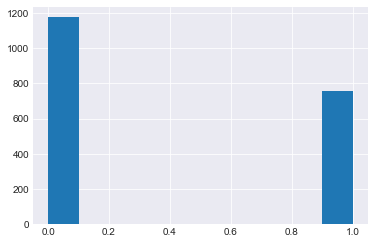

In [80]:
data_b['use.contraception'].hist()

In [81]:
data_bF = data_b[['district','age.centered','use.contraception']]
replace_map = {
    'use.contraception':{
        1:0.9999,
        0:0.0001
    }
}
data_bF = data_bF.replace(replace_map)

In [82]:
rename = {
    'use.contraception':'useContraception',
    'age.centered':'ageCentered'
}

data_bF = data_bF.rename(rename, axis=1)
data_bF.head(5)

,district,ageCentered,useContraception
0,1,18.4400,0.0001
1,1,-5.5599,0.0001
2,1,1.4400,0.0001
3,1,8.4400,0.0001
4,1,-13.5590,0.0001


In [83]:
dis = data_bF.district.unique()
distr = len(dis)
distr

60

In [84]:
data_bF.useContraception

0       0.0001
1       0.0001
2       0.0001
3       0.0001
4       0.0001
         ...  
1929    0.0001
1930    0.0001
1931    0.0001
1932    0.0001
1933    0.0001
Name: useContraception, Length: 1934, dtype: float64

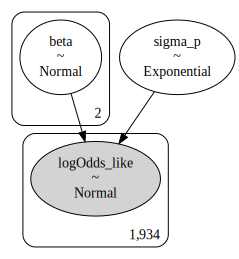

In [85]:
with Model() as pooled_model:
    beta = pm.Normal('beta', 0, sd=1e-5, shape=2)

    logOdds_hat = beta[0] + beta[1]*data_bF.ageCentered.values
    
    sigma_p = pm.Exponential("sigma_p", 1)
    
    logOdds_true = tt.log(data_bF.useContraception.values / (1 - data_bF.useContraception.values))
    
    # Data likelihood
    logOdds_like = pm.Normal('logOdds_like', mu=logOdds_hat, sd=sigma_p, observed=logOdds_true)

pm.model_to_graphviz(pooled_model)

In [86]:
with pooled_model:
    pooled_trace = pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_p, beta]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 55 seconds.


In [87]:
b0, m0 = pooled_trace['beta'].mean(axis=0)

In [88]:
import math
xvals = np.linspace(data_bF.ageCentered.min(), data_bF.ageCentered.max())
lo = m0*xvals+b0
yvals = 1 / (1 +np.exp(-lo)) 

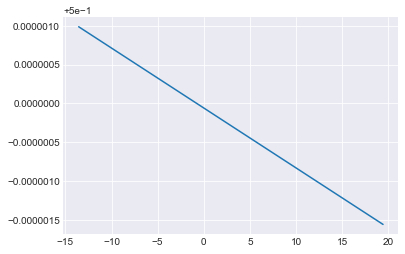

In [89]:
pp.plot(xvals, yvals);

With pooled model, you only get one model to predict all of them. We are not seeing a big impact of age on use of contraception. The model is not suffering from lack of samples in individual districts, but not very helpful differentiating between the districts. 

In [90]:
data_bF.district.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 55, 56, 57, 58, 59, 60, 61], dtype=int64)

In [91]:
replace_map = {
    'district':{
        61:54,
        54:61,
        60:0
    }
}
data_bF = data_bF.replace(replace_map)

data_bF.district.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 55, 56, 57, 58, 59,  0, 54], dtype=int64)

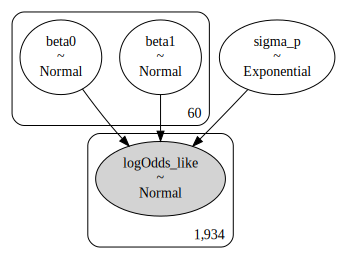

In [92]:
# Unpooled Model

with Model() as unpooled_model:
    beta0 = pm.Normal('beta0', 0, sd=1e5, shape=distr)
    beta1 = pm.Normal('beta1', 0, sd=1e5, shape=distr)
    
    sigma_p = pm.Exponential("sigma_p", 1)
    
    logOdds_true = tt.log(data_bF.useContraception.values / (1 - data_bF.useContraception.values))

    logOdds_hat = beta0[data_bF.district.values] + beta1[data_bF.district.values]*data_bF.ageCentered.values
    
    logOdds_like = pm.Normal('logOdds_like', mu=logOdds_hat, sd=sigma_p, observed=logOdds_true)
pm.model_to_graphviz(unpooled_model)

In [93]:
with unpooled_model:
    unpooled_trace =  pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_p, beta1, beta0]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 84 seconds.


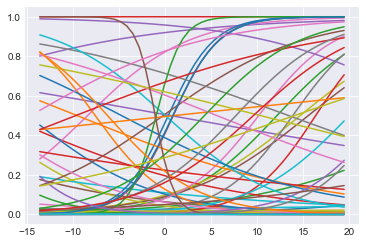

In [94]:
# Plot of pooled and unpooled estimates for some counties

sample_counties = data_bF.district.unique()

unpooled_estimates_b = pd.Series(unpooled_trace['beta1'].mean(axis=0), index=sample_counties)
unpooled_estimates_i = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=sample_counties)

#unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=mn_counties)

#m = unpooled_trace['beta1'].mean()
for i,c in enumerate(sample_counties):
    # No pooling model
    b0 = unpooled_estimates_i[c]
    b1 = unpooled_estimates_b[c]

    # Plot both models and data
    xvals = np.linspace(data_bF.ageCentered.min(), data_bF.ageCentered.max())
    lo = b1*xvals+b0
    yvals = 1 / (1 +np.exp(-lo)) 
    pp.plot(xvals, yvals)
pp.show()

With no-pooled model, we get much more detailed differences for each district, and also overall differences between the age. It looks like there are some extreme models that may have been influenced by lack of samples within the district.

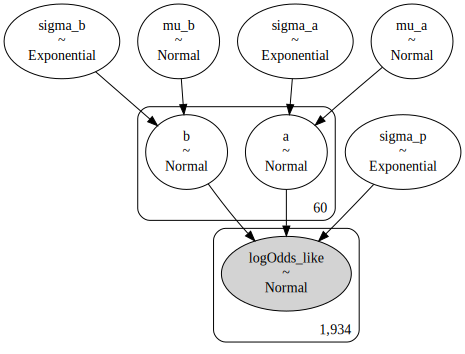

In [96]:
with Model() as hi_model:
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    #sigma_b =  pm.HalfCauchy('sigma_b', 10)
    sigma_b = pm.Exponential("sigma_b", .5)

    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=distr)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=distr)

    # Model error
    sigma_p = pm.Exponential("sigma_p", 1)
    
    logOdds_true = tt.log(data_bF.useContraception.values / (1 - data_bF.useContraception.values))
    # Expected value
    logOdds_hat = a[data_bF.district.values] + b[data_bF.district.values] * data_bF.ageCentered.values
    # Data likelihood
    logOdds_like = pm.Normal('logOdds_like', mu=logOdds_hat, sd=sigma_p, observed=logOdds_true)
pm.model_to_graphviz(hi_model)

In [98]:
with hi_model:
    hi_model_trace =  pm.sample(500, step = pm.NUTS(target_accept = 0.99), cores = 6, tune=5000)

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_p, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 6 chains for 5_000 tune and 500 draw iterations (30_000 + 3_000 draws total) took 245 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8857385182357391, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


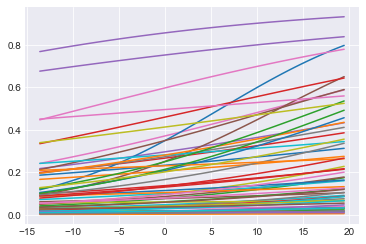

In [99]:
# Plot of pooled and unpooled estimates for some counties
unpooled_estimates_b = pd.Series(hi_model_trace['b'].mean(axis=0), index=sample_counties)
unpooled_estimates_i = pd.Series(hi_model_trace['a'].mean(axis=0), index=sample_counties)

#unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=mn_counties)

#m = unpooled_trace['beta1'].mean()
for i,c in enumerate(sample_counties):
    # No pooling model
    b0 = unpooled_estimates_i[c]
    b1 = unpooled_estimates_b[c]

    # Plot both models and data
    xvals = np.linspace(data_bF.ageCentered.min(), data_bF.ageCentered.max())
    lo = b1*xvals+b0
    yvals = 1 / (1 +np.exp(-lo)) 
    pp.plot(xvals, yvals)
pp.show()

With hierarchical model, we now have all the districts not getting extreme models due to low number of samples. The modeling is more stable and not severely influenced by the lack of data in certain districts, but is still able to delineate individual districts seperately. 